In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import datetime

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Loading the data

In [2]:
users_title = ['userID', 'gender', 'age', 'occupationID', 'zip-code']
users_old = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users_old.head()

,userID,gender,age,occupationID,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
movies_title = ['movieID', 'title', 'genres']
movies_old = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies_old.head()

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_title = ['userID','movieID', 'rating', 'timestamps']
ratings_old = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings_old.head()

,userID,movieID,rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 2. Dara Preprocessing:

In [5]:
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')

# Mapping gender to number[0, 1] 
users['gender'] = users['gender'].astype('category')
users['gender'] = users['gender'].cat.codes

# Mapping age range from age gourp to 0 - 7
age_mapping = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
users['age'] = users['age'].map(age_mapping)

# Dropping the zip-code columm
# users.drop('zip-code')
users.drop('zip-code', axis=1, inplace=True)

print("User table after preprocessing")
users.head()

User table after preprocessing


,userID,gender,age,occupationID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


In [6]:
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')

# Mapping the genres to the fixed length (len = 18) padded list
genres_types = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", 
                "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", 
                "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

def genresToList(s):
    result = [genres_types.index(g) + 1 for g in s.split("|")]
    result = result + [0 for i in range(18 - len(result))]
    return result;
    
movies['genres'] = movies['genres'].apply(genresToList)

# Remove year from title and mapping the title to the fixed length (len = 18) padded list
def removeYear(s):
    return s[:-7]
movies['title'] = movies['title'].apply(removeYear)

title_words = set()
for title in movies["title"]:
    for word in title.split(" "):
        title_words.add(word)
title_words = list(title_words)
        
def titleToList(s):
    result = [title_words.index(g) + 1 for g in s.split(" ")]
    result = result + [0 for i in range(15 - len(result))]
    return result;

movies['title'] = movies['title'].apply(titleToList)

print("Movie table after preprocessing")
movies.head()

Movie table after preprocessing


,movieID,title,genres
0,1,"[4269, 5129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[1052, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[4811, 2290, 1366, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,"[1533, 2175, 1636, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[1373, 605, 4829, 4526, 1255, 3771, 0, 0, 0, 0...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.drop('timestamps', axis=1, inplace=True)

print("Rating table after preprocessing")
ratings.head()

Rating table after preprocessing


,userID,movieID,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [8]:
data = pd.merge(pd.merge(ratings, users), movies)

X_df, y_df = data.drop('rating', axis=1), data['rating']
    
X_all = X_df.values
y_all = y_df.values

## 3. Building the Network

### Dimensions of Inputs

In [10]:
print("User table dimensions:")
user_id_count = users['userID'].nunique()+1
print("user_id_count:", user_id_count)

user_gender_count = users['gender'].nunique()
print("user_gender_count:", user_gender_count)

user_age_count = users['age'].nunique()
print("user_age_count:", user_age_count)

user_occupation_count = users['occupationID'].nunique()
print("user_occupation_count:", user_occupation_count)


print("\nMovies table dimensions:")
movie_id_count = max(movies["movieID"]) + 1
print("movie_id_count:", movie_id_count)

movie_title_count = len(title_words) + 1
print("movies_title_count:", movie_title_count)

movie_title_len = 15
print("movies_title_len:", movie_title_len)

movie_genres_count = len(genres_types) + 1
print("movies_genres_count:", movie_genres_count)

User table dimensions:
user_id_count: 6041
user_gender_count: 2
user_age_count: 7
user_occupation_count: 21

Movies table dimensions:
movie_id_count: 3953
movies_title_count: 5215
movies_title_len: 15
movies_genres_count: 19


### Model

In [86]:
class MovieRecommendationModel():
    def __init__(self, learning_rate, embed_dim = 32, filter_num = 8, window_sizes = {2, 3, 4, 5}):
        
        self.dropout_keep_prob = tf.placeholder(tf.float32)
        self.ratings = tf.placeholder(tf.int32, [None, 1])
        
        ###########################
        # User Features Embedding #
        ###########################
        self.user_id = tf.placeholder(tf.int32, [None, 1])
        self.user_gender = tf.placeholder(tf.int32, [None, 1])
        self.user_age = tf.placeholder(tf.int32, [None, 1])
        self.user_job = tf.placeholder(tf.int32, [None, 1])
        
        uid_embed_matrix = tf.Variable(tf.random_uniform([user_id_count, embed_dim], -1, 1))
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, self.user_id)
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([user_gender_count, embed_dim // 2], -1, 1))
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, self.user_gender)
        
        age_embed_matrix = tf.Variable(tf.random_uniform([user_age_count, embed_dim // 2], -1, 1))
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, self.user_age)
        
        job_embed_matrix = tf.Variable(tf.random_uniform([user_occupation_count, embed_dim // 2], -1, 1))
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, self.user_job)

        # First FC 
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, activation=tf.nn.relu)
        
        # Second FC
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
        
        
        #############################
        # Movies Features Embedding #
        #############################
        self.movie_id = tf.placeholder(tf.int32, [None, 1])
        self.movie_genres = tf.placeholder(tf.int32, [None, 18])
        self.movie_titles = tf.placeholder(tf.int32, [None, 15])
        
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_count, embed_dim], -1, 1))
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, self.movie_id)
        
        movie_genres_embed_matrix = tf.Variable(tf.random_uniform([movie_genres_count, embed_dim], -1, 1))
        movie_genres_embed_layer = tf.nn.embedding_lookup(movie_genres_embed_matrix, self.movie_genres)
        movie_genres_embed_layer = tf.reduce_sum(movie_genres_embed_layer, axis=1, keep_dims=True)
        
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_count, embed_dim], -1, 1))
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, self.movie_titles)
        movie_title_embed_layer = tf.reduce_sum(movie_title_embed_layer, axis=1, keep_dims=True)


        # First FC Layer
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, activation=tf.nn.relu)
        movie_genres_fc_layer = tf.layers.dense(movie_genres_embed_layer, embed_dim, activation=tf.nn.relu)
        movie_title_fc_layer = tf.layers.dense(movie_title_embed_layer, embed_dim, activation=tf.nn.relu)
    
        # Second FC Layer
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_genres_fc_layer, movie_title_fc_layer], 2)  
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
        
        
        pred_ratings = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        self.pred_ratings = tf.expand_dims(pred_ratings, axis=1)
        
        cost = tf.losses.mean_squared_error(self.ratings, self.pred_ratings )
        self.loss = tf.reduce_mean(cost)
        
        self.global_step = tf.train.get_or_create_global_step()
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver()

### Training the model

In [87]:
tf.reset_default_graph()
model = MovieRecommendationModel(learning_rate = 0.0001)

In [88]:
model_file = "models/final_movies_recommendations_model"

losses = {'train':[], 'test':[]}


# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256
dropout_keep_prob = 0.5

# Show stats for every n number of batches
show_every_n_batches = 20



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_index in range(num_epochs):
        train_X,test_X, train_y, test_y = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)  
        
        for batch_index in range(len(train_X) // batch_size):
            
            start_index = batch_index * batch_size
            end_index = min((batch_index+1)*batch_size , len(train_X))
            x = train_X[start_index:end_index]
            y = train_y[start_index:end_index]

            genres = np.zeros([batch_size, 18])
            for i in range(batch_size):
                genres[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, movie_title_len])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                model.user_id: np.reshape(x.take(0,1), [batch_size, 1]),
                model.user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                model.user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                model.user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                model.movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                model.movie_genres: genres,  
                model.movie_titles: titles,  
                model.ratings: np.reshape(y, [batch_size, 1]),
                model.dropout_keep_prob: dropout_keep_prob
                }

            step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed)  #cost
            losses['train'].append(train_loss)

            if(batch_index % show_every_n_batches == 0):
                print('Epoch: ',epoch_index,' Batch: ',batch_index,"/",len(train_X)//batch_size,'train_loss:',train_loss)
    
    model.saver.save(sess, model_file)

Epoch:  0  Batch:  0 / 3125 train_loss: 45.92952
Epoch:  0  Batch:  20 / 3125 train_loss: 6.6519213
Epoch:  0  Batch:  40 / 3125 train_loss: 4.4100714
Epoch:  0  Batch:  60 / 3125 train_loss: 2.8271098
Epoch:  0  Batch:  80 / 3125 train_loss: 2.3507607
Epoch:  0  Batch:  100 / 3125 train_loss: 2.0651507
Epoch:  0  Batch:  120 / 3125 train_loss: 2.1276565
Epoch:  0  Batch:  140 / 3125 train_loss: 1.9820973
Epoch:  0  Batch:  160 / 3125 train_loss: 1.6276827
Epoch:  0  Batch:  180 / 3125 train_loss: 1.7095152
Epoch:  0  Batch:  200 / 3125 train_loss: 1.7110256
Epoch:  0  Batch:  220 / 3125 train_loss: 1.5151602
Epoch:  0  Batch:  240 / 3125 train_loss: 1.5769289
Epoch:  0  Batch:  260 / 3125 train_loss: 1.6753664
Epoch:  0  Batch:  280 / 3125 train_loss: 1.6482515
Epoch:  0  Batch:  300 / 3125 train_loss: 1.6682382
Epoch:  0  Batch:  320 / 3125 train_loss: 1.6478379
Epoch:  0  Batch:  340 / 3125 train_loss: 1.3686538
Epoch:  0  Batch:  360 / 3125 train_loss: 1.352354
Epoch:  0  Batch:  3

Epoch:  0  Batch:  3120 / 3125 train_loss: 0.99696624
Epoch:  1  Batch:  0 / 3125 train_loss: 1.2627752
Epoch:  1  Batch:  20 / 3125 train_loss: 1.0628741
Epoch:  1  Batch:  40 / 3125 train_loss: 1.1364341
Epoch:  1  Batch:  60 / 3125 train_loss: 0.9504841
Epoch:  1  Batch:  80 / 3125 train_loss: 1.1361308
Epoch:  1  Batch:  100 / 3125 train_loss: 1.2025025
Epoch:  1  Batch:  120 / 3125 train_loss: 1.233949
Epoch:  1  Batch:  140 / 3125 train_loss: 1.161137
Epoch:  1  Batch:  160 / 3125 train_loss: 1.019345
Epoch:  1  Batch:  180 / 3125 train_loss: 1.1083473
Epoch:  1  Batch:  200 / 3125 train_loss: 1.3672626
Epoch:  1  Batch:  220 / 3125 train_loss: 1.1486139
Epoch:  1  Batch:  240 / 3125 train_loss: 1.1341122
Epoch:  1  Batch:  260 / 3125 train_loss: 1.1801536
Epoch:  1  Batch:  280 / 3125 train_loss: 1.2028058
Epoch:  1  Batch:  300 / 3125 train_loss: 1.1725489
Epoch:  1  Batch:  320 / 3125 train_loss: 1.2639608
Epoch:  1  Batch:  340 / 3125 train_loss: 1.0002515
Epoch:  1  Batch:  

Epoch:  1  Batch:  3120 / 3125 train_loss: 0.9112665
Epoch:  2  Batch:  0 / 3125 train_loss: 1.0739379
Epoch:  2  Batch:  20 / 3125 train_loss: 0.9529214
Epoch:  2  Batch:  40 / 3125 train_loss: 1.0261157
Epoch:  2  Batch:  60 / 3125 train_loss: 0.8175447
Epoch:  2  Batch:  80 / 3125 train_loss: 1.0048189
Epoch:  2  Batch:  100 / 3125 train_loss: 1.0711725
Epoch:  2  Batch:  120 / 3125 train_loss: 1.0781959
Epoch:  2  Batch:  140 / 3125 train_loss: 1.0446535
Epoch:  2  Batch:  160 / 3125 train_loss: 0.8692248
Epoch:  2  Batch:  180 / 3125 train_loss: 0.9920111
Epoch:  2  Batch:  200 / 3125 train_loss: 1.2036651
Epoch:  2  Batch:  220 / 3125 train_loss: 1.0328631
Epoch:  2  Batch:  240 / 3125 train_loss: 1.0431936
Epoch:  2  Batch:  260 / 3125 train_loss: 1.0272353
Epoch:  2  Batch:  280 / 3125 train_loss: 1.0535004
Epoch:  2  Batch:  300 / 3125 train_loss: 1.105937
Epoch:  2  Batch:  320 / 3125 train_loss: 1.1459008
Epoch:  2  Batch:  340 / 3125 train_loss: 0.8751153
Epoch:  2  Batch: 

Epoch:  2  Batch:  3120 / 3125 train_loss: 0.87244916
Epoch:  3  Batch:  0 / 3125 train_loss: 1.0214763
Epoch:  3  Batch:  20 / 3125 train_loss: 0.8875773
Epoch:  3  Batch:  40 / 3125 train_loss: 0.95585096
Epoch:  3  Batch:  60 / 3125 train_loss: 0.76859164
Epoch:  3  Batch:  80 / 3125 train_loss: 0.92287314
Epoch:  3  Batch:  100 / 3125 train_loss: 0.9975845
Epoch:  3  Batch:  120 / 3125 train_loss: 1.0003259
Epoch:  3  Batch:  140 / 3125 train_loss: 0.9762056
Epoch:  3  Batch:  160 / 3125 train_loss: 0.80363744
Epoch:  3  Batch:  180 / 3125 train_loss: 0.9116775
Epoch:  3  Batch:  200 / 3125 train_loss: 1.1026936
Epoch:  3  Batch:  220 / 3125 train_loss: 0.9528003
Epoch:  3  Batch:  240 / 3125 train_loss: 0.99488014
Epoch:  3  Batch:  260 / 3125 train_loss: 0.9592123
Epoch:  3  Batch:  280 / 3125 train_loss: 0.9843594
Epoch:  3  Batch:  300 / 3125 train_loss: 1.0736194
Epoch:  3  Batch:  320 / 3125 train_loss: 1.054177
Epoch:  3  Batch:  340 / 3125 train_loss: 0.79653955
Epoch:  3  

Epoch:  3  Batch:  3080 / 3125 train_loss: 1.0277853
Epoch:  3  Batch:  3100 / 3125 train_loss: 0.98015773
Epoch:  3  Batch:  3120 / 3125 train_loss: 0.8415786
Epoch:  4  Batch:  0 / 3125 train_loss: 0.9901511
Epoch:  4  Batch:  20 / 3125 train_loss: 0.8613374
Epoch:  4  Batch:  40 / 3125 train_loss: 0.91468436
Epoch:  4  Batch:  60 / 3125 train_loss: 0.7471137
Epoch:  4  Batch:  80 / 3125 train_loss: 0.8645395
Epoch:  4  Batch:  100 / 3125 train_loss: 0.9565268
Epoch:  4  Batch:  120 / 3125 train_loss: 0.95485854
Epoch:  4  Batch:  140 / 3125 train_loss: 0.9370911
Epoch:  4  Batch:  160 / 3125 train_loss: 0.77109754
Epoch:  4  Batch:  180 / 3125 train_loss: 0.8732782
Epoch:  4  Batch:  200 / 3125 train_loss: 1.040536
Epoch:  4  Batch:  220 / 3125 train_loss: 0.90599304
Epoch:  4  Batch:  240 / 3125 train_loss: 0.9672131
Epoch:  4  Batch:  260 / 3125 train_loss: 0.9313061
Epoch:  4  Batch:  280 / 3125 train_loss: 0.9537469
Epoch:  4  Batch:  300 / 3125 train_loss: 1.0519927
Epoch:  4  

Epoch:  4  Batch:  3040 / 3125 train_loss: 0.8987607
Epoch:  4  Batch:  3060 / 3125 train_loss: 0.7778839
Epoch:  4  Batch:  3080 / 3125 train_loss: 1.0058441
Epoch:  4  Batch:  3100 / 3125 train_loss: 0.9718087
Epoch:  4  Batch:  3120 / 3125 train_loss: 0.8234869


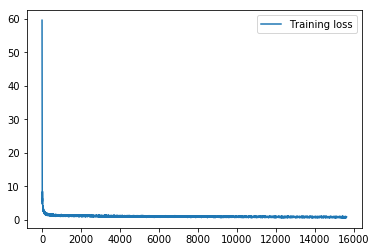

In [79]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 4. Usage of pre-trained Model:

In [89]:
movie_id_map = {val[0]:i for i, val in enumerate(movies.values)}

In [90]:
def rating_movie(user_id_val, movie_id_val):
    
    with tf.Session() as sess:  
        model.saver.restore(sess, model_file)
        
        genres = np.zeros([1, 18])
        genres[0] = movies.values[movie_id_map[movie_id_val]][2]
    
        titles = np.zeros([1, movie_title_len])
        titles[0] = movies.values[movie_id_map[movie_id_val]][1]
    
        feed = {
              model.user_id: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              model.user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              model.user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              model.user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              model.movie_id: np.reshape(movies.values[movie_id_map[movie_id_val]][0], [1, 1]),
              model.movie_genres: genres,  
              model.movie_titles: titles,  
              model.dropout_keep_prob: 1
        }
    
        # Get Prediction
        pred_rating= sess.run([model.pred_ratings], feed)  
    
        return (pred_rating)

In [91]:
rating_movie(2, 1193)

INFO:tensorflow:Restoring parameters from models/final_movies_recommendations_model


[array([[4.1669364]], dtype=float32)]